## Predicting Crashes in Financial Markets - Logistic Regression
- Datasets: S&P500 (USA), Nikkei225 (Japan), SSE (Shanghai/China), HSI (Hong Kong), BSESN (India), SMI (Switzerland), BVSP (Brazil)
- Model: Logistic Regression
- Number of features: 504 (252 past days of price chages and volatility for each trading date)
- Response variable: Crash within 1 / 3 / 6 months (0: no, 1:yes)
- Crash definition: Drawdown in 99.5% quantile

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
from datetime import timedelta#, datetime
from sklearn import linear_model, metrics
from pylab import rcParams
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
##### load data sets
os.chdir('/home/roman/Documents/Projects/Bubbles/data')
datasets_original = ['^GSPC.csv', '^N225.csv', 'SSE.csv','^HSI.csv', '^BSESN.csv',\
                     '^SSMI.csv', '^BVSP.csv']
dataset_names = ['S&P 500', 'N225', 'SSE', 'HSI', 'BSESN', 'SMI', 'BVSP']
datasets = []
for d in datasets_original:
    data_original = pd.read_csv(d, index_col = 'Date')
    data_original.index = pd.to_datetime(data_original.index, format='%Y/%m/%d')
    data_norm = data_original['Close'] / data_original['Close'][-1]
    data_ch = data_original['Close'].pct_change()
    window = 10
    data_vol = data_original['Close'].pct_change().rolling(window).std()
    data = pd.concat([data_original['Close'], data_norm, data_ch, data_vol], axis=1).dropna()
    data.columns = ['price', 'norm', 'ch', 'vol']
    datasets.append(data)
datasets[5] = datasets[5].loc['1990-11-09':,:]  # <-- SMI has much missing data before 11/9/90

In [3]:
##### find crashes
drawdowns = []
crashes = []
# crash thresholds identified in 'eploration.ipynb', 99.5% quartile):
crash_thresholds = [-0.091, -0.109, -0.120, -0.144, -0.166, -0.110, -0.233]
for df, ct in zip(datasets, crash_thresholds):
    pmin_pmax = (df['price'].diff(-1) > 0).astype(int).diff() #<- -1 indicates pmin, +1 indicates pmax
    pmax = pmin_pmax[pmin_pmax == 1]
    pmin = pmin_pmax[pmin_pmax == -1]
    # make sure drawdowns start with pmax, end with pmin:
    if pmin.index[0] < pmax.index[0]:
        pmin = pmin.drop(pmin.index[0])
    if pmin.index[-1] < pmax.index[-1]:
        pmax = pmax.drop(pmax.index[-1])
    D = (np.array(df['price'][pmin.index]) - np.array(df['price'][pmax.index])) \
    / np.array(df['price'][pmax.index])
    d = {'Date':pmax.index, 'drawdown':D, 'd_start': pmax.index, 'd_end': pmin.index}    
    df_d = pd.DataFrame(d).set_index('Date')
    df_d.index = pd.to_datetime(df_d.index, format='%Y/%m/%d')
    df_d = df_d.reindex(df.index).fillna(0)
    df_d = df_d.sort_values(by='drawdown')
    df_d['rank'] = list(range(1,df_d.shape[0]+1))
    drawdowns.append(df_d)
    df_d = df_d.sort_values(by='Date')
    df_c = df_d[df_d['drawdown'] < ct]
    df_c.columns = ['drawdown', 'crash_st', 'crash_end', 'rank']
    c_st = list(df_c['crash_st'])
    d_st = [df['price'][(c_s-timedelta(int(252*5/12))):c_s].idxmax() for c_s in c_st] 
    d_st_adj = [max(d, c_prev) for d, c_prev in zip(d_st[1:], c_st[:-1])]
    d_st_adj = [d_st[0]] + d_st_adj
    df_c['down_st'] = d_st_adj
    crashes.append(df_c)
df_combined = []  
for i in range(len(datasets)):
    df_combined.append(pd.concat([datasets[i], drawdowns[i]], axis=1))

In [4]:
##### Prepare features for prediction models (504 features)
m = 3 # <-- number of months ahead to predict a crash 1, 3 or 6
dfs_xy = []
for df, c in zip(df_combined, crashes):
    xy = {}
    #for date in df.index[255:-126]: # <--subtract 126 days in the end
    for i in range(252, df.shape[0]-126):
        date = df.index[i]
        x_ch = [df['ch'].iloc[i-j] for j in range(252)]
        x_vol = [df['vol'].iloc[i-j] for j in range(252)]
        xy[date] = x_ch + x_vol
        xy[date].append(max([date <= c and date+timedelta(3*21) > c for c in c['crash_st']]))
    df_xy = pd.DataFrame.from_dict(xy, orient='index').dropna()
    dfs_xy.append(df_xy)
    
# create two training and test sets for each df:
np_xy = np.concatenate(([np.array(xy) for xy in dfs_xy]))
split = [0]
i = 0
for df in dfs_xy:
    i += df.shape[0]-1
    split.append(i)
np_train = [] 
np_test = [] 
n = 12 * 252  # <-- 12 years test data
for j in range(len(dfs_xy) * 2):
    i = round(j/2 + 0.1)
    if j % 2 == 0:
        np_test.append(np_xy[split[i]:split[i]+n, :])
        np_train.append(np.concatenate(([np_xy[0:split[i],:], np_xy[split[i]+n:,:]])))
    if j % 2 == 1:
        np_test.append(np_xy[split[i]-n:split[i], :])
        np_train.append(np.concatenate(([np_xy[0:split[i]-n,:], np_xy[split[i]:,:]])))

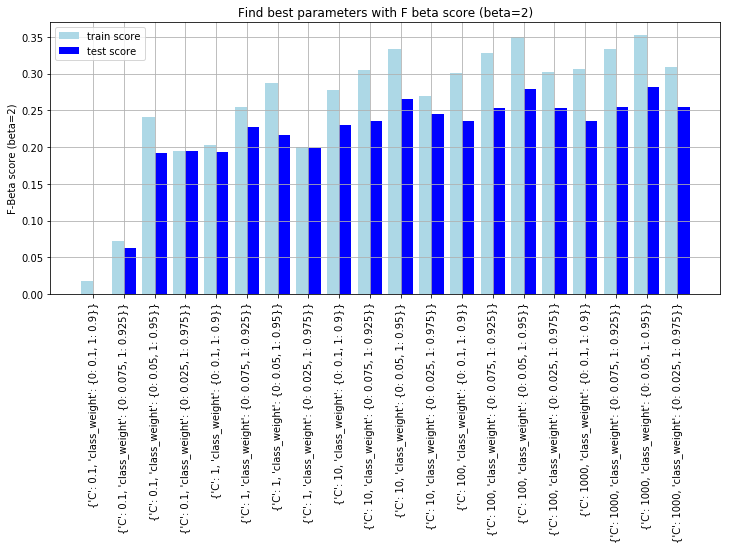

In [5]:
##### Find best parameters with grid search:
model_name = 'Logistic Regression'
beta = 2
# Find parameters with grid search:
fbeta_scorer = make_scorer(fbeta_score, beta=beta)
#param_grid = [{'C': [0.1, 1, 10, 100, 1000], 'class_weight': [{0:.05, 1:.95}, {0:.04, 1:.96}, \
#                {0:.03, 1:.97}, {0:.025, 1:.975}, {0:.02, 1:.98}]}]   # <-- 1 month
param_grid = [{'C': [0.1, 1, 10, 100, 1000], 'class_weight': [{0:.1, 1:.9}, {0:.075, 1:.925}, \
               {0:.05, 1:.95}, {0:.025, 1:.975}]}]   # <-- 3 months
# param_grid = [{'C': [0.1, 1, 10, 100, 1000], 'class_weight': [{0:.11, 1:.89}, {0:.1, 1:.9}, \
#                {0:.09, 1:.91}, {0:.08, 1:.92}]}]   # <-- 6 months
clf = GridSearchCV(linear_model.LogisticRegression(penalty='l2'), param_grid, scoring=fbeta_scorer)
x_tr = np_train[0][:, 0:-2]
y_tr = np_train[0][:, -1].astype(int)  
model = clf.fit(x_tr, y_tr)
labels = model.cv_results_['params']
tr_score = model.cv_results_['mean_train_score']
t_score = model.cv_results_['mean_test_score']

# Plot grid search results:
rcParams['figure.figsize'] = 12, 5
plt.bar(x=np.arange(len(tr_score))-0.2,width=0.4, height=tr_score, color='lightblue', label='train score')
plt.bar(x=np.arange(len(t_score))+0.2,width=0.4, height=t_score, color='blue', label='test score')
plt.title('Find best parameters with F beta score (beta=2)')
plt.xticks(np.arange(len(labels)), labels, rotation=90)
plt.ylabel('F-Beta score (beta=2)')
plt.legend()
plt.grid()
plt.show()

In [8]:
##### Logistic Regression results with best parametes
clf = linear_model.LogisticRegression(C=1000, class_weight={0:.075, 1:.925})
precision_tr = []
recall_tr = []
accuracy_tr = []
precision_t = []
recall_t = []
accuracy_t = []
y_pred_bin_t_all = []  # <-- store all test predictions here
y_pred_bin_tr_all = []
y_actual = []
y_tr_actual = []
score_fbeta_tr = []
score_fbeta_t = []
for train, test in zip(np_train, np_test):
    x_tr = train[:, 0:-1]
    y_tr = train[:, -1].astype(int)  #<- crash as response variable
    y_tr_actual.append(y_tr)
    x_t = test[:, 0:-1]
    y_t = test[:, -1].astype(int)
    y_actual.append(y_t)
    model = clf.fit(x_tr, y_tr)
    y_pred_bin_tr = model.predict(x_tr)
    y_pred_bin_tr_all.append(y_pred_bin_tr) 
    precision_tr.append(metrics.precision_score(y_tr, y_pred_bin_tr))
    recall_tr.append(metrics.recall_score(y_tr, y_pred_bin_tr))
    accuracy_tr.append(metrics.accuracy_score(y_tr, y_pred_bin_tr))
    score_fbeta_tr.append(metrics.fbeta_score(y_tr, y_pred_bin_tr, beta=beta))
    y_pred_bin_t = model.predict(x_t)
    y_pred_bin_t_all.append(y_pred_bin_t)  #<- list of test predictions for plots
    precision_t.append(metrics.precision_score(y_t, y_pred_bin_t))
    recall_t.append(metrics.recall_score(y_t, y_pred_bin_t))
    accuracy_t.append(metrics.accuracy_score(y_t, y_pred_bin_t))
    score_fbeta_t.append(metrics.fbeta_score(y_t, y_pred_bin_t, beta=beta))
avg_pr_tr = sum(precision_tr) / len(precision_tr)
avg_re_tr = sum(recall_tr) / len(recall_tr)
avg_ac_tr = sum(accuracy_tr) / len(accuracy_tr)
avg_pr_t = sum(precision_t) / len(precision_t)
avg_re_t = sum(recall_t) / len(recall_t)
avg_ac_t = sum(accuracy_t) / len(accuracy_t)
avg_score_fbeta_tr = sum(score_fbeta_tr) / len(score_fbeta_tr)
avg_score_fbeta_t = sum(score_fbeta_t) / len(score_fbeta_t)

# calculate precision, recall, accuracy for comparable random model
rnd_y_tr_pos = sum(sum(y_pred_bin_tr_all)) / (len(y_pred_bin_tr_all[0])*len(y_pred_bin_tr_all))
y_tr_pos = sum(sum(y_tr_actual)) / (len(y_tr_actual[0])*len(y_tr_actual))
rnd_TP = rnd_y_tr_pos * y_tr_pos
rnd_FP = rnd_y_tr_pos * (1 - y_tr_pos)
rnd_TN = (1-rnd_y_tr_pos) * (1 - y_tr_pos)
rnd_FN = (1-rnd_y_tr_pos) * y_tr_pos
rnd_pr_tr = rnd_TP / (rnd_TP+rnd_FP)
rnd_re_tr = rnd_TP / (rnd_TP+rnd_FN)
rnd_ac_tr = rnd_TP + rnd_TN
rnd_y_t_pos = sum(sum(y_pred_bin_t_all)) / (len(y_pred_bin_t_all[0])*len(y_pred_bin_t_all))
y_t_pos = sum(sum(y_actual)) / (len(y_actual[0])*len(y_actual))
rnd_TP = rnd_y_t_pos * y_t_pos
rnd_FP = rnd_y_t_pos * (1 - y_t_pos)
rnd_TN = (1-rnd_y_t_pos) * (1 - y_t_pos)
rnd_FN = (1-rnd_y_t_pos) * y_t_pos
rnd_pr_t = rnd_TP / (rnd_TP+rnd_FP)
rnd_re_t = rnd_TP / (rnd_TP+rnd_FN)
rnd_ac_t = rnd_TP + rnd_TN

print('Results ' + model_name + ':')
print('Number of features: ' + str(dfs_xy[0].shape[1]-2) + '; number of rows: ' \
      + str(np_xy.shape[0]))
print('Positive train cases actual:        '+ str(round(y_tr_pos, 2)))
print('Positive train cases predicted:     '+ str(round(rnd_y_tr_pos, 2)))
print('Avg precision train (model/random): '+ str(round(avg_pr_tr, 2))+' / '+str(round(rnd_pr_tr, 2)))
print('Avg recall train (model/random):    '+ str(round(avg_re_tr, 2))+' / '+str(round(rnd_re_tr, 2)))
print('Avg accuracy train (model/random):  '+ str(round(avg_ac_tr, 2))+' / '+str(round(rnd_ac_tr, 2)))
print('Score train fbeta:                  '+ str(round(avg_score_fbeta_tr, 2)))
print('Positive test cases actual:         '+ str(round(y_t_pos, 2)))
print('Positive test cases predicted:      '+ str(round(rnd_y_t_pos, 2)))
print('Avg precision test (model/random):  '+ str(round(avg_pr_t, 2))+' / '+str(round(rnd_pr_t, 2)))
print('Avg recall test (model/random):     '+ str(round(avg_re_t, 2))+' / '+str(round(rnd_re_t, 2)))
print('Avg accuracy test (model/random):   '+ str(round(avg_ac_t, 2))+' / '+str(round(rnd_ac_t, 2)))
print('Score test fbeta:                   '+ str(round(avg_score_fbeta_t, 2)))

Results Logistic Regression:
Number of features: 503; number of rows: 59945
Positive train cases actual:        0.04
Positive train cases predicted:     0.12
Avg precision train (model/random): 0.15 / 0.04
Avg recall train (model/random):    0.41 / 0.12
Avg accuracy train (model/random):  0.87 / 0.85
Score train fbeta:                  0.3
Positive test cases actual:         0.05
Positive test cases predicted:      0.16
Avg precision test (model/random):  0.14 / 0.05
Avg recall test (model/random):     0.44 / 0.16
Avg accuracy test (model/random):   0.84 / 0.81
Score test fbeta:                   0.28


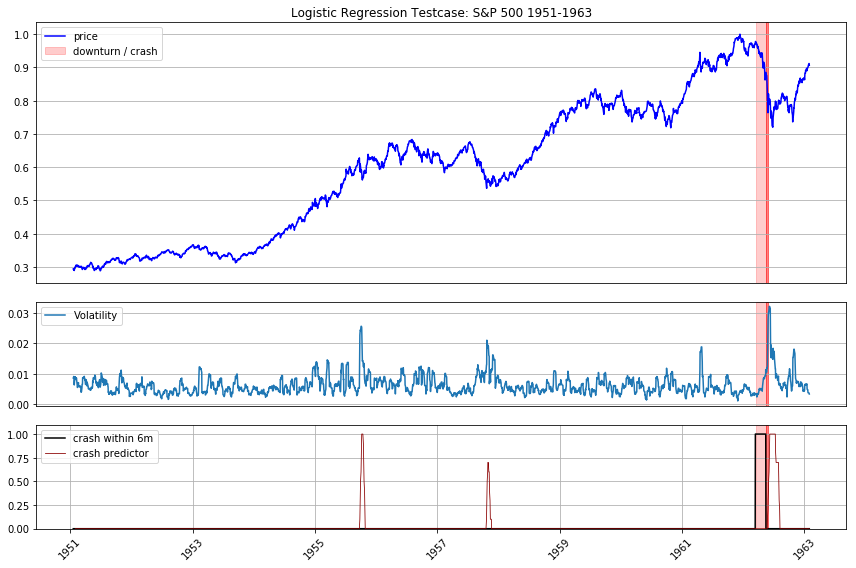

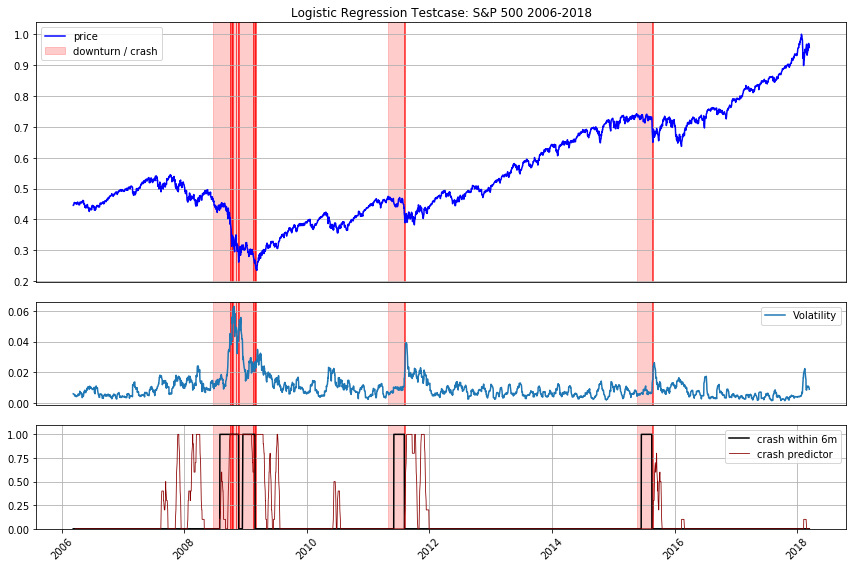

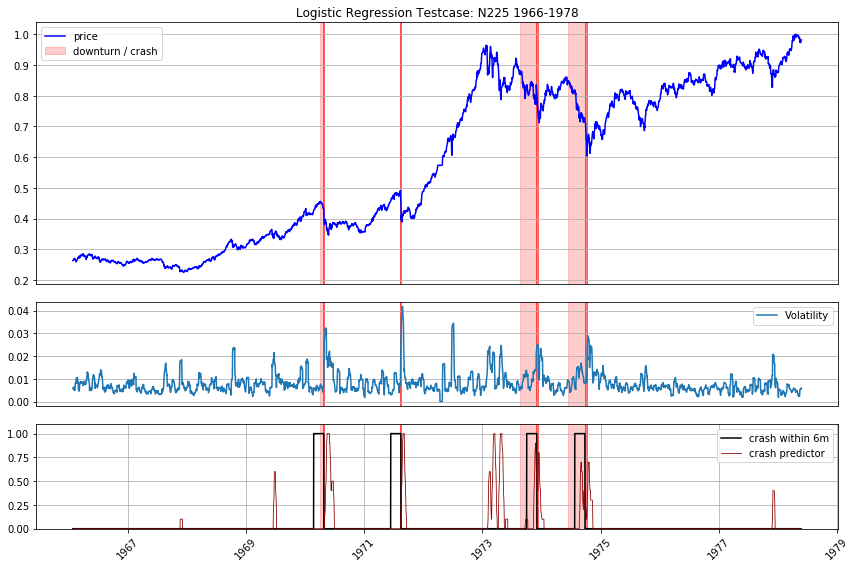

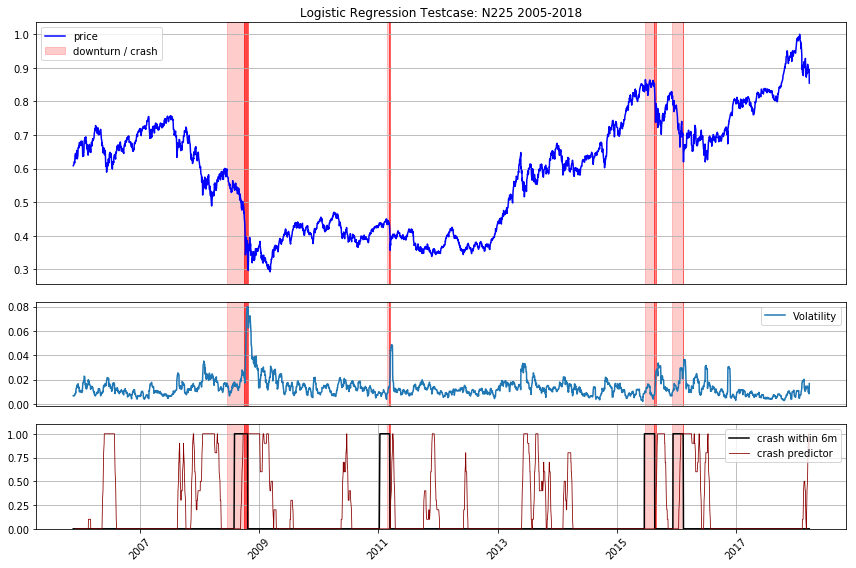

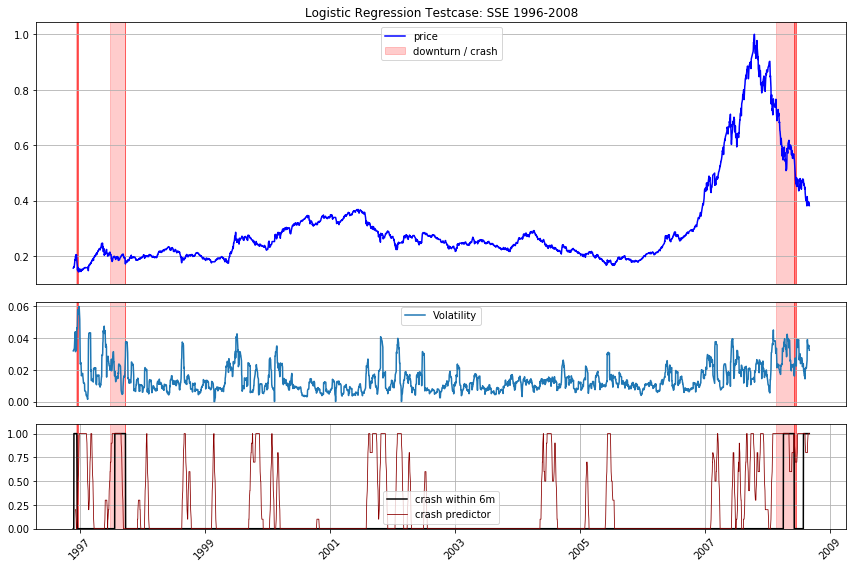

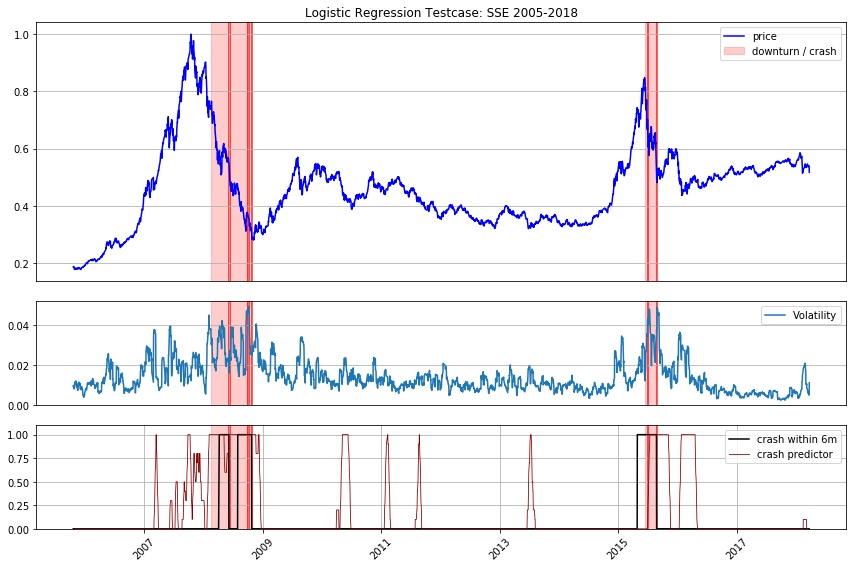

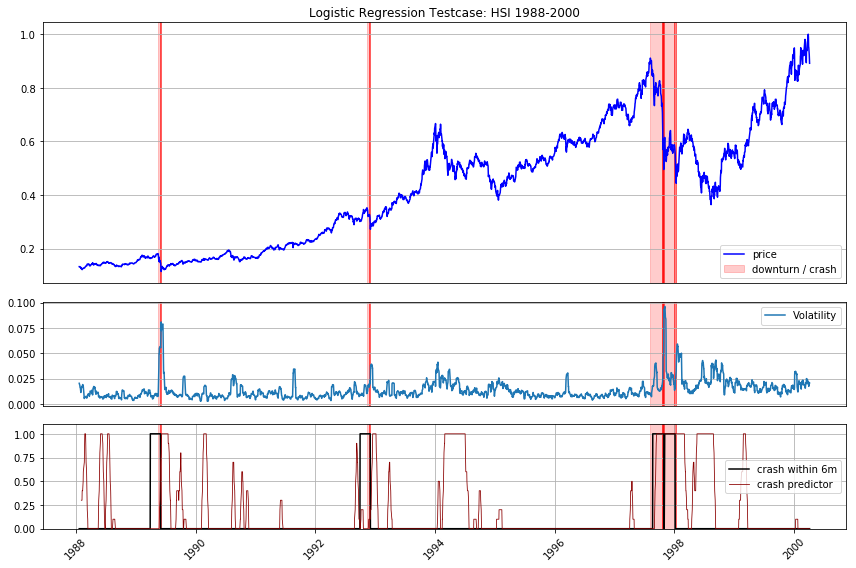

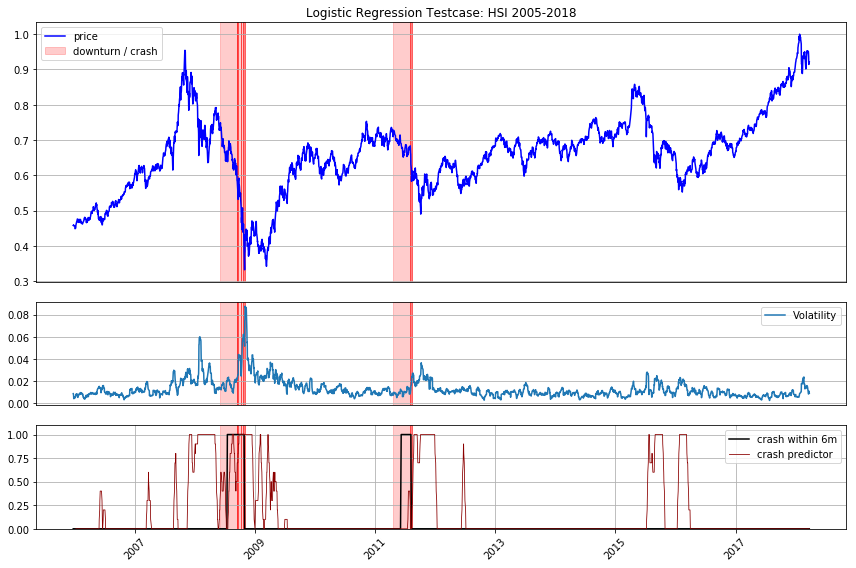

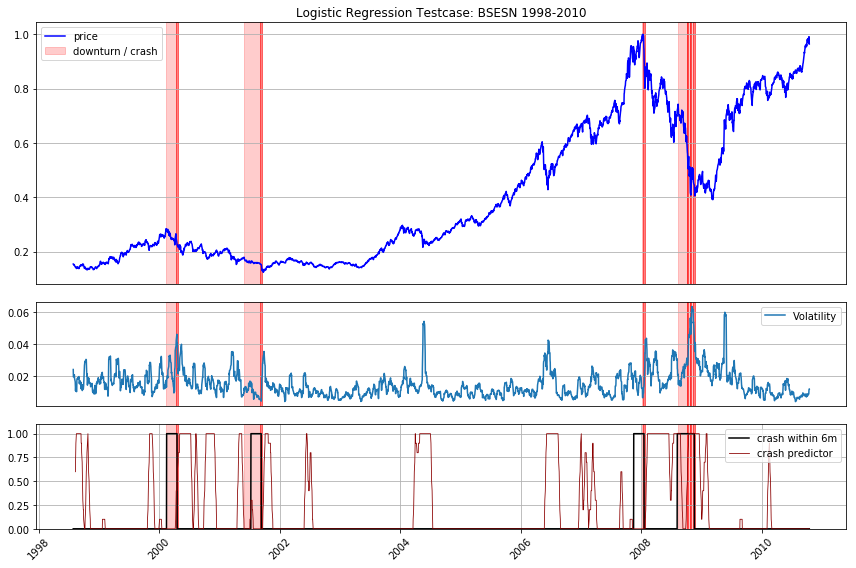

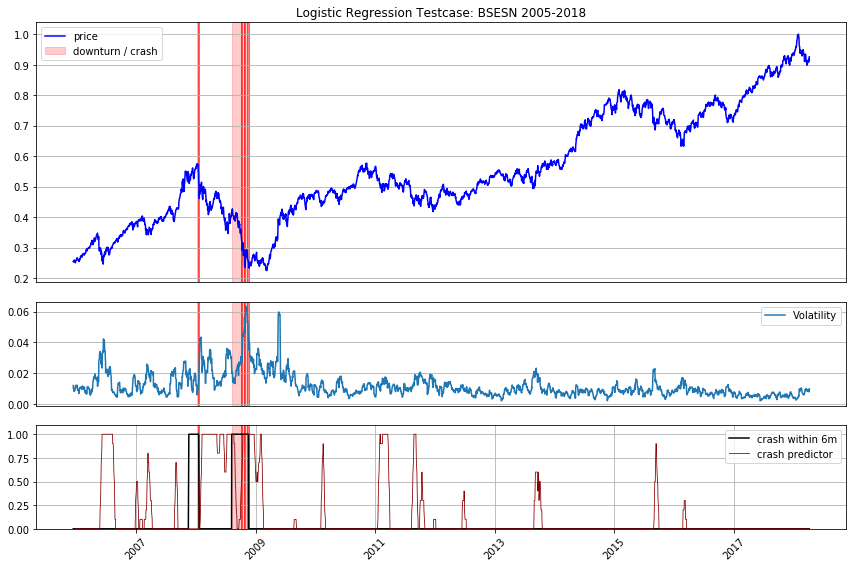

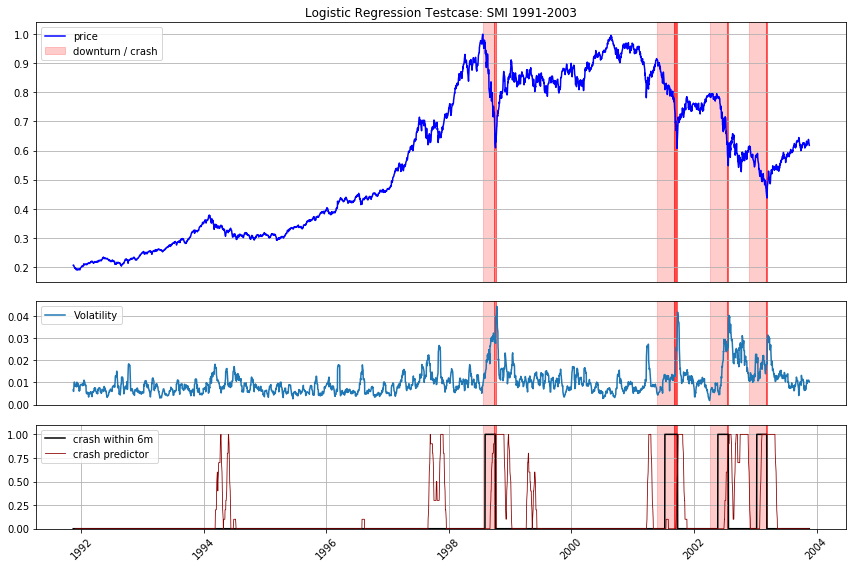

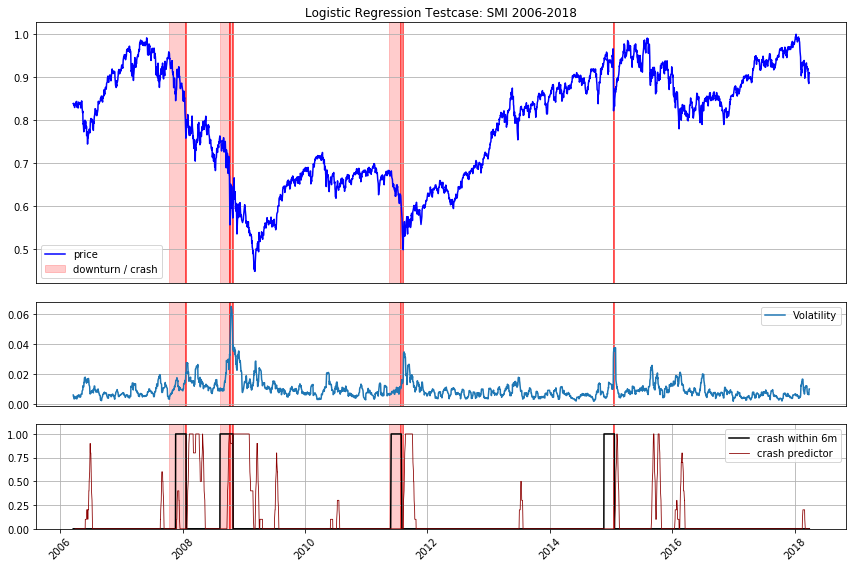

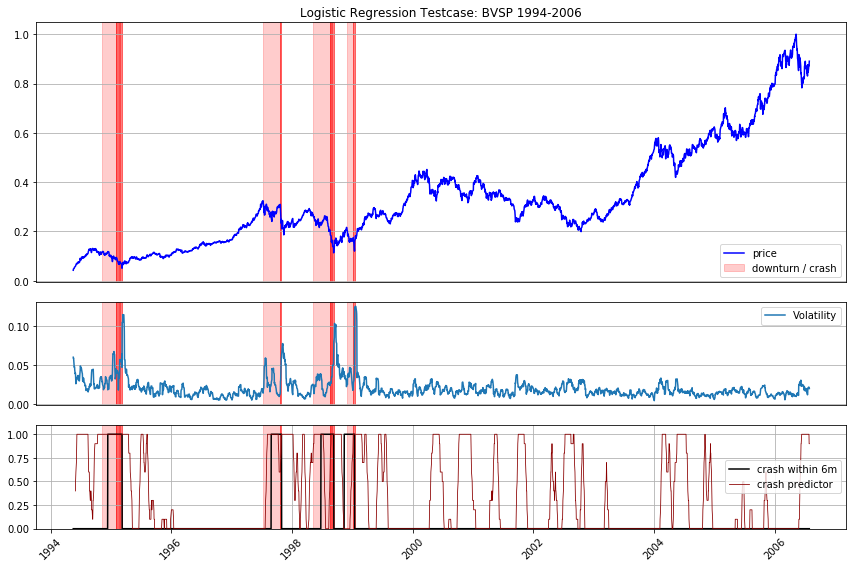

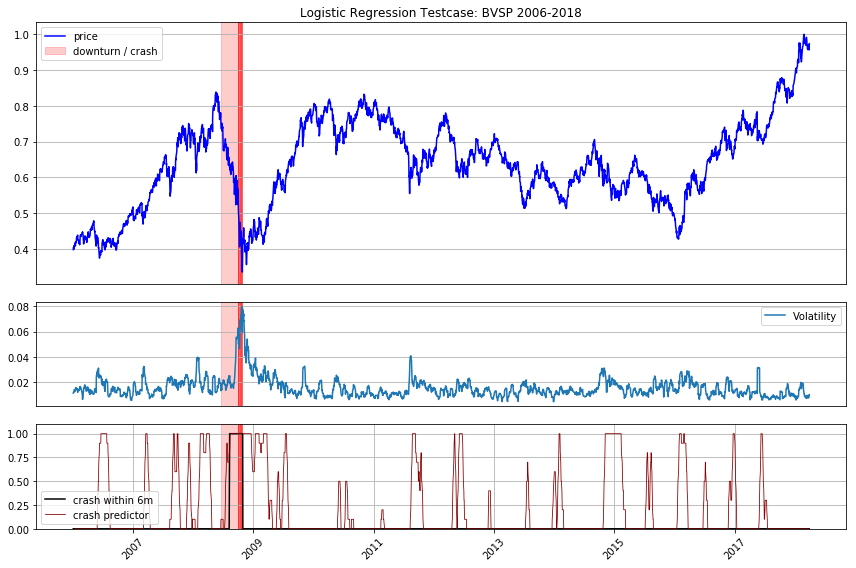

In [9]:
##### Plots for all test cases:
df_combined = [dfc.reindex(dfs.index) for dfc, dfs in zip(df_combined, dfs_xy)]
dfs_predict = []
for j in range(len(datasets)*2):
    i = round(j/2 + 0.1)
    k = round(j/2 - 0.1)
    if j % 2 == 0:
        df = df_combined[k].iloc[:n, :]
        df['y_pred'] = y_pred_bin_t_all[j]
        df['y'] = y_actual[j]
        dfs_predict.append(df)
    if j % 2 == 1:       
        df = df_combined[k].iloc[-n:, :]
        df['y_pred'] = y_pred_bin_t_all[j]
        df['y'] = y_actual[j]
        dfs_predict.append(df)
cr_ext = []
for c in crashes:
    cr_ext.append(c)
    cr_ext.append(c)
ds_name_ext = []
for ds_name in dataset_names:
    ds_name_ext.append(ds_name)
    ds_name_ext.append(ds_name)    
rcParams['figure.figsize'] = 12, 8
gs = gridspec.GridSpec(3, 1, height_ratios=[2.5, 1, 1]) 
for df, c, t in zip(dfs_predict, cr_ext, ds_name_ext):
    t1 = df.index[0]
    t2 = df.index[-1]
    plt.subplot(gs[0])
    down_st = list(filter(lambda x: x > t1 and x < t2, c['down_st']))
    crash_st = list(filter(lambda x: x > t1 and x < t2, c['crash_st']))
    crash_end = list(filter(lambda x: x > t1 and x < t2, c['crash_end']))
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    df_norm = df['price'][t1:t2] / df['price'][t1:t2].max()
    plt.plot(df_norm[t1:t2], color='blue') 
    plt.title(model_name + ' Testcase: ' + t + ' ' + str(df.index[0].year) + '-' \
              + str(df.index[-1].year))
    plt.legend(['price', 'downturn / crash'])
    plt.xticks([])
    plt.grid()     
    plt.subplot(gs[1])
    plt.plot(df.loc[t1:t2, 'vol'])
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['Volatility'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.xticks([])
    plt.subplot(gs[2])
    plt.plot(df['y'][t1:t2], color='black')
    plt.plot(df['y_pred'][t1:t2].rolling(10).mean(), color='darkred', linewidth=0.8)
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(down_st, crash_st)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['crash within 6m', 'crash predictor'])
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.show()  